# Optimise pruning parameters

This Notebook shows how to optimise the pruning parameters of your network based on pairwise connectivity data.

First we need to create a small network that we can use for the optimisation of the pruning parameters.

In this example we do not need to have realistic neuron densities, so we will place the neurons in a cube of diameter 150 micrometers.

In [1]:
import os
import numpy as np

n_neurons = 150

pop_size = 15
# epochs = 10

pre_type = "ChIN"     # "iSPN"
post_type = "iSPN"  # "iSPN"
con_type = "GABA"

avg_num_synapses_per_pair = 3  # Expected mean, error weight

# param_names = ["f1", "softMax", "mu2", "a3"]
param_names = ["f1", "mu2", "a3"]

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
FS_dist_dep_pruning = "exp(-(0.5*d/60e-6)**2)" 
LTS_dist_dep_pruning = "1-exp(-(0.4*d/60e-6)**2)"


extra_pruning_parameters = { }
# extra_pruning_parameters = { 'distPruning': SPN2SPNdistDepPruning }
    
        
par_str = "_".join(param_names)
network_path = os.path.join("networks", f"{pre_type}_to_{post_type}_{par_str}")

        
all_experimental_data = {}
all_experimental_data["dSPN", "iSPN"] = [(0, 50e-6, 3/47.0), (0, 100e-6, 3/66.0)]
all_experimental_data["dSPN", "dSPN"] = [(0, 50e-6, 5/19.0), (0, 100e-6, 3/43.0)]
all_experimental_data["iSPN", "iSPN"] = [(0, 50e-6, 14/39.0), (0, 100e-6, 7/31.0)]
all_experimental_data["iSPN", "dSPN"] = [(0, 50e-6, 13/47.0), (0, 100e-6, 10/80.0)]

all_experimental_data["FS", "FS"] = [(0, 250e-6, 7/12.0)]
all_experimental_data["FS", "iSPN"] = [(0, 100e-6, 6/9.0), (0, 150e-6, 21/54.0), (0, 250e-6, 27/77.0)]
all_experimental_data["FS", "dSPN"] = [(0, 100e-6, 8/9.0), (0, 150e-6, 29/48.0), (0, 250e-6, 48/90.0)]
all_experimental_data["FS", "LTS"] = [(0, 250e-6, 2/12.0)]

all_experimental_data["LTS", "dSPN"] = [(0, 250e-6, 2/60.0)]
all_experimental_data["LTS", "iSPN"] = [(0, 250e-6, 2/60.0)]

all_experimental_data["ChIN", "dSPN"] = [(0, 250e-6, 0.05)]
all_experimental_data["ChIN", "iSPN"] = [(0, 250e-6, 0.05)]
all_experimental_data["ChIN", "LTS"] = [(0, 250e-6, 53/72.0)]  # Lou ea 2013
all_experimental_data["ChIN", "FS"] = [(0, 250e-6, 19/26.0)]   # Lou ea 2013



all_experimental_data["NGF", "dSPN"] = [(0, 100e-6, 25/29.0),  # Ibanez-Sandoval 2011
                                        (0, 250e-6, 11/14.0),  # English 2012
                                        (0, 250e-6, 30/50.0)]  # Luo 2013
all_experimental_data["NGF", "iSPN"] = [(0, 100e-6, 25/29.0),  # Ibanez-Sandoval 2011
                                        (0, 250e-6, 11/14.0),  # English 2012
                                        (0, 250e-6, 30/50.0)]  # Luo 2013
all_experimental_data["NGF", "ChIN"] = [(0, 250e-6, 3/14.0)]  # English 2012

# NGF to FS??   Kocaturk 2022 -- no probability given?
# NGF to NGF??


experimental_data = all_experimental_data[pre_type, post_type]

cube_side = np.max([x[1] for x in experimental_data])

axon_cloud = dict()
LTS_density_str = ("12*3000*1e12*( 0.25*exp(-(((x-200e-6)/100e-6)**2 "
                           "+ ((y-0)/50e-6)**2 + ((z-0)/30e-6)**2)) "
                           "+ 1*exp(-(((x-300e-6)/300e-6)**2 + ((y-0)/15e-6)**2 + ((z-0)/10e-6)**2)) "
                           "+ 1*exp(-(((x-700e-6)/100e-6)**2 + ((y-0)/15e-6)**2 + ((z-0)/15e-6)**2)) )")

axon_cloud["LTS"] = ("xyz", LTS_density_str, [-200e-6, 900e-6, -100e-6, 100e-6, -30e-6, 30e-6])
# axon_cloud["CHIN"] = ("r", "5000*1e12/3*exp(-r/120e-6)", 350e-6)

In [2]:
from snudda.place.create_cube_mesh import create_cube_mesh

mesh_file = os.path.join(network_path, "cube-mesh.obj")
create_cube_mesh(mesh_file, [0,0,0], cube_side)

from snudda.init import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=123, snudda_data="../../../../../BasalGangliaData/data/")

si.define_structure(struct_name="Cube", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)

if pre_type in axon_cloud:
    pre_ac = axon_cloud[pre_type]
else:
    pre_ac = None
    
if post_type in axon_cloud:
    post_ac = axon_cloud[post_type]
else:
    post_ac = None

if pre_type == post_type:
    
    si.add_neurons(name=pre_type, num_neurons=n_neurons, volume_id="Cube", axon_density=pre_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum",pre_type.lower()))
else:
    si.add_neurons(name=pre_type, num_neurons=int(n_neurons/2), volume_id="Cube", axon_density=pre_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum", pre_type.lower()))
    si.add_neurons(name=post_type, num_neurons=int(n_neurons/2), volume_id="Cube", axon_density=post_ac,
                    neuron_dir=os.path.join("$DATA","neurons","striatum", post_type.lower()))
    

# The parameters here does not matter, they will be set during optimisation
si.add_neuron_target(neuron_name=pre_type,
                     target_name=post_type,
                     region_name="Cube",
                     connection_type=con_type,
                     dist_pruning=None,
                     f1=None, soft_max=None, mu2=None,
                     a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     mod_file="tmGabaA")

si.write_json()

Adding neurons: ChIN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/chin
Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn
Writing networks/ChIN_to_iSPN_f1_mu2_a3/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/ChIN_to_iSPN_f1_mu2_a3/network-config.json
No n_putative_points and putative_density, setting n_putative_points = 6172
(this must be larger than the number of neurons you want to place)
Generating 6172 points for networks/ChIN_to_iSPN_f1_mu2_a3/cube-mesh.obj
Filtering, keeping inside points: 2413 / 3257
neuron_name = 'ChIN_0', num = 75, neuron_path = '/home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/chin/str-chin-e170614_cell6-m17JUL301751_170614_no6_MD_cell_1_x63-v20190710'
neuron_name = 'iSPN_0', num = 18, neuron_path = '/home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn/str-ispn-e150908_c4_D2-m51-5-DE-v20220622'
neuron_name = 'iSPN_1', num = 19, neuron_path = '/home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn/str-ispn-e150917_c11_D2-mWT-MSN1-v20220623'
neuron_name = 'iSPN_2', num = 19, neuron_path = '/home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/ispn/str-ispn-e151123_c1_D2-

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/ChIN_to_iSPN_f1_mu2_a3/network-config.json


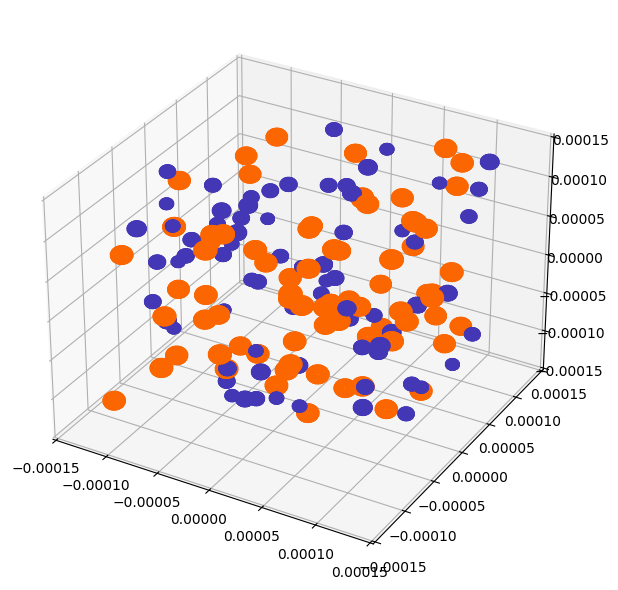

In [4]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=100)
sd.detect()

Reading SNUDDA_DATA=/home/hjorth/HBP/BasalGangliaData/data from networks/ChIN_to_iSPN_f1_mu2_a3/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 114/343 (148 neurons)
Processing hyper voxel : 115/343 (143 neurons)
Processing hyper voxel : 121/343 (138 neurons)
Processing hyper voxel : 122/343 (123 neurons)
Processing hyper voxel : 163/343 (118 neurons)
Processing hyper voxel : 164/343 (110 neurons)
Processing hyper voxel : 170/343 (99 neurons)
Processing hyper voxel : 171/343 (93 neurons)
Processing hyper voxel : 65/343 (77 neurons)
Processing hyper voxel : 107/343 (69 neurons)
Processing hyper voxel : 66/343 (65 neurons)
Processing hyper voxel : 108/343 (65 neurons)
Processing hyper voxel : 72/343 (64 neurons)
Processing hyper voxel : 113/343 (60 neurons)
Processing hyper voxel : 73/343 (52 neurons)
Processing hyper voxel : 156/343 (48 neurons)
Processing hyper voxel : 157/343 (44 neurons)
Processing hyper voxel : 162/343 (39 neuro

In [6]:
from snudda.optimise.optimise_pruning import OptimisePruning
op = OptimisePruning(network_path=network_path)

In [7]:
op.merge_putative_synapses(force_merge=True)

Read 48092 out of total 48092 synapses


In [8]:
op.prune.connectivity_distributions

{(1,
  2,
  10): ({'f1': 1.0,
   'soft_max': None,
   'mu2': None,
   'a3': None,
   'dist_pruning': None,
   'cluster_pruning': False}, None)}

In [9]:
op.prune.type_id_lookup

{'ChIN': 1, 'iSPN': 2}

In [10]:
op.prune.hist_file["meta/connectivity_distributions"][()]

b'{"ChIN$$iSPN": {"GABA": {"conductance": [2.4e-10, 1e-10], "channel_parameters": {"mod_file": "tmGabaA"}, "cluster_size": 1, "cluster_spread": null, "pruning": {"f1": null, "soft_max": null, "mu2": null, "a3": null, "dist_pruning": null, "cluster_pruning": false}, "channel_model_id": 10, "lognormal_mu_sigma": [-22.230424900260093, 0.40010675493807013]}}}'

In [11]:
res = op.optimize(pre_type=pre_type, post_type=post_type, con_type=con_type, 
                  experimental_data=experimental_data, 
                  avg_num_synapses_per_pair=avg_num_synapses_per_pair,
                  extra_pruning_parameters=extra_pruning_parameters, 
                  workers=8, maxiter=1000, pop_size=pop_size, tol=0.00001, 
                  param_names=param_names, param_bounds="default")

/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Worker iter: 100, fitness 4.2301872787484305
Worker iter: 100, fitness 4.110774372627882
Worker iter: 100, fitness 4.406049963179063
Worker iter: 100, fitness 4.216997369846059Worker iter: 100, fitness 4.167407110168439

Worker iter: 100, fitness 4.087133455291102
Worker iter: 100, fitness 4.241737757335116
Worker iter: 100, fitness 4.2132286073974825
Worker iter: 200, fitness 3.9920920406531923
Worker iter: 200, fitness 3.9883192260420914
Worker iter: 200, fitness 3.9920920406531923
Worker iter: 200, fitness 3.9920920406531923
Worker iter: 200, fitness 3.9920920406531923
Worker iter: 200, fitness 3.9883192260420914
Worker iter: 200, fitness 3.9920920406531923
Worker iter: 200, fitness 3.9883192260420914
Worker iter: 300, fitness 3.9722507708119226
Worker iter: 300, fitness 3.9722507708119226
Worker iter: 300, fitness 3.9722507708119226
Worker iter: 300, fitness 3.9722507708119226
Worker iter: 300, fitness 3.9722507708119226
Worker iter: 300, fitness 3.9722507708119226
Worker iter: 300

In [18]:
op.export_json("network-config-opt.json", res=res, append=True)

# Best parameter set

In [13]:
param_str = ""
for p_name, p_val in zip(param_names, res.x):
    param_str += f"{p_name} = {p_val:.4f}, "
    
if "distPruning" in extra_pruning_parameters:
   param_str += f" ({extra_pruning_parameters['distPruning']})"                                                  
                                                 
print(param_str)

f1 = 0.0517, mu2 = 2.2161, a3 = 0.8309, 


In [14]:
res

             message: Optimization terminated successfully.
             success: True
                 fun: 3.9722507708119226
                   x: [ 5.175e-02  2.216e+00  8.309e-01]
                 nit: 58
                nfev: 2659
          population: [[ 5.175e-02  2.216e+00  8.309e-01]
                       [ 5.176e-02  2.216e+00  8.321e-01]
                       ...
                       [ 5.177e-02  2.214e+00  8.292e-01]
                       [ 5.176e-02  2.213e+00  8.300e-01]]
 population_energies: [ 3.972e+00  3.972e+00 ...  3.972e+00  3.972e+00]

In [15]:
import os
from snudda.analyse.analyse import SnuddaAnalyse
import glob

# Get the last file
# list_of_files = glob.glob(os.path.join(network_path, "temp", "network-synapses-*hdf5"))
# network_file = max(list_of_files, key=os.path.getctime)

network_file = os.path.join(network_path, "network-synapses.hdf5")

dist3D = False
y_max_H = None

sa = SnuddaAnalyse(network_file)

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Creating figures directory networks/ChIN_to_iSPN_f1_mu2_a3/figures
Number of neurons: 150
Synapse row 0 - 0.0 % time: 0.0009822500001064327 seconds
Created connection matrix 0.0017832920002547326 seconds
Created gap junction connection matrix 0.00013795899985780125 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 720, at 0
Created distance histogram (optimised) in 0.0011239579998800764 seconds
Saving cache to networks/ChIN_to_iSPN_f1_mu2_a3/network-synapses.hdf5-cache


Plotting connection probability ChIN to iSPN (synapses)
Centering in None : Keeping 75/75
Counting connections
Requested: 10000000.0 calculated [5625.]
P(d<0.00025) = 0.04859632139399806


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1439: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


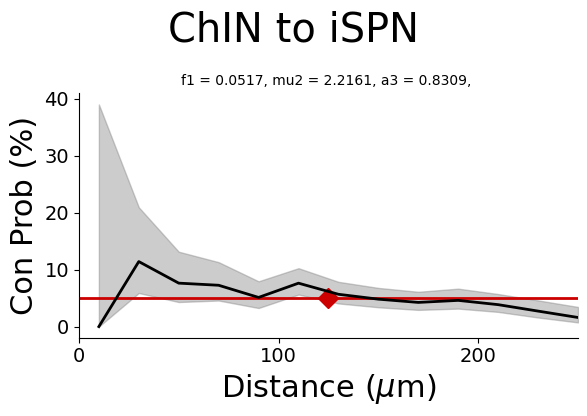

Wrote networks/ChIN_to_iSPN_f1_mu2_a3/figures/Network-distance-dependent-connection-probability-ChIN-to-iSPN-synapses-3D-dist.png
Plotting number of connections
Only analysing centre post synaptic neurons, sideLen = 0.00025
Centering in None : Keeping 75/75
Calculating max synapses
Calculating mean synapses
Plotting 252 connections


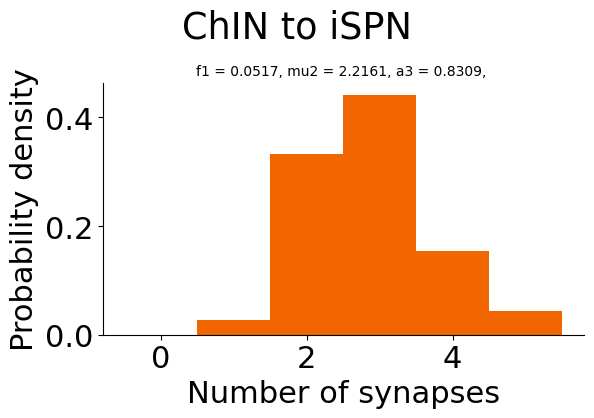

Wrote networks/ChIN_to_iSPN_f1_mu2_a3/figures/Network-number-of-synapses-from-ChIN-to-iSPN-per-cell.png


In [16]:
if pre_type == "dSPN" and post_type == "iSPN":
    sa.plot_connection_probability("dSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "iSPN", sub_title=param_str)
elif pre_type == "dSPN" and post_type == "dSPN":
    sa.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(5, 19), (3, 43)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "dSPN", sub_title=param_str)
elif pre_type == "iSPN" and post_type == "iSPN":
    sa.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(14, 39), (7, 31)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "iSPN", sub_title=param_str)
elif pre_type == "iSPN" and post_type == "dSPN":
    sa.plot_connection_probability("iSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(13, 47), (10, 80)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "dSPN", sub_title=param_str)

elif pre_type == "FS" and post_type == "FS":
    sa.plot_connection_probability("FS", "FS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(7, 12)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "FS", sub_title=param_str)
elif pre_type == "FS" and post_type == "iSPN":
    sa.plot_connection_probability("FS", "iSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(6, 9), (21, 54), (27,77)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "iSPN", sub_title=param_str)
elif pre_type == "FS" and post_type == "dSPN":
    sa.plot_connection_probability("FS", "dSPN", dist_3d=True, exp_max_dist=[100e-6, 150e-6, 250e-6], exp_data_detailed=[(8, 9), (29, 48), (48,90)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "dSPN", sub_title=param_str)    
elif pre_type == "FS" and post_type == "LTS":
    sa.plot_connection_probability("FS", "LTS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 12)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("FS", "LTS", sub_title=param_str)
    
elif pre_type == 'LTS' and post_type == "dSPN":
    sa.plot_connection_probability("LTS", "dSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 60)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "dSPN", sub_title=param_str)
elif pre_type == 'LTS' and post_type == "iSPN":
    sa.plot_connection_probability("LTS", "iSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(2, 60)], sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "iSPN", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "dSPN":
    sa.plot_connection_probability("ChIN", "dSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data=[0.05], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "dSPN", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "iSPN":
    sa.plot_connection_probability("ChIN", "iSPN", dist_3d=True, exp_max_dist=[250e-6], exp_data=[0.05], sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "iSPN", sub_title=param_str)

# Missing pairwise experimental data...
    
elif pre_type == 'ChIN' and post_type == "FS":
    sa.plot_connection_probability("ChIN", "FS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(19, 26)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "FS", sub_title=param_str)
elif pre_type == 'ChIN' and post_type == "LTS":
    sa.plot_connection_probability("ChIN", "LTS", dist_3d=True, exp_max_dist=[250e-6], exp_data_detailed=[(53,72)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("ChIN", "LTS", sub_title=param_str)

elif pre_type == 'LTS' and post_type == "ChIN":
    sa.plot_connection_probability("LTS", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("LTS", "ChIN", sub_title=param_str)

    
elif pre_type == 'dSPN' and post_type == "ChIN":
    sa.plot_connection_probability("dSPN", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("dSPN", "ChIN", sub_title=param_str)
elif pre_type == 'iSPN' and post_type == "ChIN":
    sa.plot_connection_probability("iSPN", "ChIN", dist_3d=True, sub_title=param_str)
    sa.plot_num_synapses_per_pair("iSPN", "ChIN", sub_title=param_str)

elif pre_type == 'NGF' and post_type == "dSPN":
    sa.plot_connection_probability("NGF", "dSPN", dist_3d=True, 
                                   exp_max_dist=[100e-6, 250e-6, 250e-6],
                                   exp_data_detailed=[(25,29), (11,14), (30,50)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "dSPN", sub_title=param_str)
elif pre_type == 'NGF' and post_type == "iSPN":
    sa.plot_connection_probability("NGF", "iSPN", dist_3d=True, 
                                   exp_max_dist=[100e-6, 250e-6, 250e-6],
                                   exp_data_detailed=[(25,29), (11,14), (30,50)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "iSPN", sub_title=param_str)
elif pre_type == 'NGF' and post_type == "ChIN":
    sa.plot_connection_probability("NGF", "ChIN", dist_3d=True, 
                                   exp_max_dist=[250e-6],
                                   exp_data_detailed=[(3,14)],
                                   sub_title=param_str)
    sa.plot_num_synapses_per_pair("NGF", "ChIN", sub_title=param_str)



